In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

# ensure the backend is set
if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "torch"

import keras

# import keras
from keras.src.backend.common import global_state

global_state.set_global_attribute("torch_device", "cpu")



In [2]:
%load_ext autoreload
%autoreload 2
import bayesflow as bf


In [3]:
species_to_keep = [
	# 'time',
	# blood species
	'Cent.Teff_1_0',
	'Cent.Treg',
	'Cent.nT_CD4',
	'Cent.nT_CD8',
	'Cent.Nivo',
	# lymph node species
	'LN.Nivo',
	'LN.APC',
	'LN.mAPC',
	'LN.nT_CD8',
	'LN.nT_CD4',
	'LN.Treg',
	'LN.aTreg_CD4',
	'LN.IL2',
	'LN.Cp',
	'LN.D1_0',
	'LN.aT_1_0',
	'LN.Teff_1_0',
	# tumor species
	'Tum.Nivo',
	'Tum.APC',
	'Tum.mAPC',
	'Tum.C1',
	'Tum.Cp',
	'Tum.Ckine_Mat',
	'Tum.Treg',
	'Tum.Teff_PD1',
	'Tum.D1_0',
	'Tum.Teff_1_0',
	'Tum.Teff_exhausted',
	'Tum.DAMP',
	'Tum.C1_PDL1',
	'Tum.C1_PDL2'
]

In [4]:
# get all QSP_0.csv files from the experiments folder
exp_dir = '../experiments/exp4/exp4/subject_1'
qsp_paths = [os.path.join(exp_dir, entry,'QSP_0.csv') for entry in os.listdir(exp_dir) if 'sample' in entry]


In [5]:
# def read_offline_data(obs_path, param_path, validation_ratio: float = 0.02):
observables = []
for path in qsp_paths:
	obs = pd.read_csv(path, index_col=0, header=0)
	# keep only the columns we are interested in
	obs = obs[species_to_keep]
	observables.append(np.expand_dims(obs.to_numpy(),axis=0))


In [6]:
observables = np.concatenate(observables, axis=0)

In [7]:
params_df = pd.read_csv('../experiments/exp4/exp4/subject_1/param_log.csv', index_col=0, header=0)

In [8]:
params = params_df.to_numpy()

In [9]:
validation_ratio = 0.02
split = int(validation_ratio * params.shape[0])
train = {"kd": params[split:], 
					"sim_data": observables[split:]}
validation = {"kd": params[:split], 
							"sim_data": observables[:split]}   

In [10]:
# adapter = (
#     bf.adapters.Adapter()
    
#     # convert any non-arrays to numpy arrays
#     .to_array()
    
#     # convert from numpy's default float64 to deep learning friendly float32
#     .convert_dtype("float64", "float32")
    
#     # standardize all variables to zero mean and unit variance
#     .standardize()
    
#     # rename the variables to match the required approximator inputs
#     .rename("theta", "inference_variables")
#     .rename("x", "inference_conditions")
# )
# adapter

In [11]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .as_time_series("sim_data")
    .concatenate(["kd"], into="inference_variables")
    # .rename("prior_draws", "inference_variables")
    .rename("sim_data", "summary_variables")
    # since all our variables are non-negative (zero or larger)
    # this .apply call ensures that the variables are transformed
    # to the unconstrained real space and can be back-transformed under the hood
    .apply(forward=lambda x: np.log1p(x), inverse=lambda x: np.expm1(x))
    # .standardize()
)

In [12]:
adapted_sims = adapter(train)
print(adapted_sims["summary_variables"].shape)
print(adapted_sims["inference_variables"].shape)

(98, 1461, 31)
(98, 1)


In [13]:
adapted_sims["summary_variables"].max()

25.466745

In [14]:
class GRU(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.gru = keras.layers.GRU(64, dropout=0.1)
        self.summary_stats = keras.layers.Dense(8)
        
    def call(self, time_series, **kwargs):
        """Compresses time_series of shape (batch_size, T, 1) into summaries of shape (batch_size, 8)."""

        summary = self.gru(time_series, training=kwargs.get("stage") == "training")
        summary = self.summary_stats(summary)
        return summary

In [15]:
summary_net = GRU()

In [16]:
inference_net = bf.networks.FlowMatching(
    subnet_kwargs={"residual": True, "dropout": 0.1, "widths": (128, 128, 128)}
)

In [17]:
workflow = bf.BasicWorkflow(
    adapter=adapter,
    inference_network=inference_net,
    summary_network=summary_net,
    inference_variables=["kd"]
)

In [18]:
history = workflow.fit_offline(train, epochs=15, batch_size=16, validation_data=validation)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - loss: 3.0803 - loss/inference_loss: 3.0803 - val_loss: 5.0933 - val_loss/inference_loss: 5.0933
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - loss: 2.5388 - loss/inference_loss: 2.5388 - val_loss: 0.7017 - val_loss/inference_loss: 0.7017
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 455ms/step - loss: 2.6300 - loss/inference_loss: 2.6300 - val_loss: 1.0267 - val_loss/inference_loss: 1.0267
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - loss: 2.4586 - loss/inference_loss: 2.4586 - val_loss: 3.2473 - val_loss/inference_loss: 3.2473
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - loss: 2.1276 - loss/inference_loss: 2.1276 - val_loss: 0.8665 - val_loss/inference_loss: 0.8665
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - loss: 1.9221 - loss/inference_loss: 1.9221 - val_loss: 2.1755 - val_loss/inference_loss: 2.1755
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - loss: 1.2843 - loss/inference_loss: 1.2843 - val_loss: 0.120

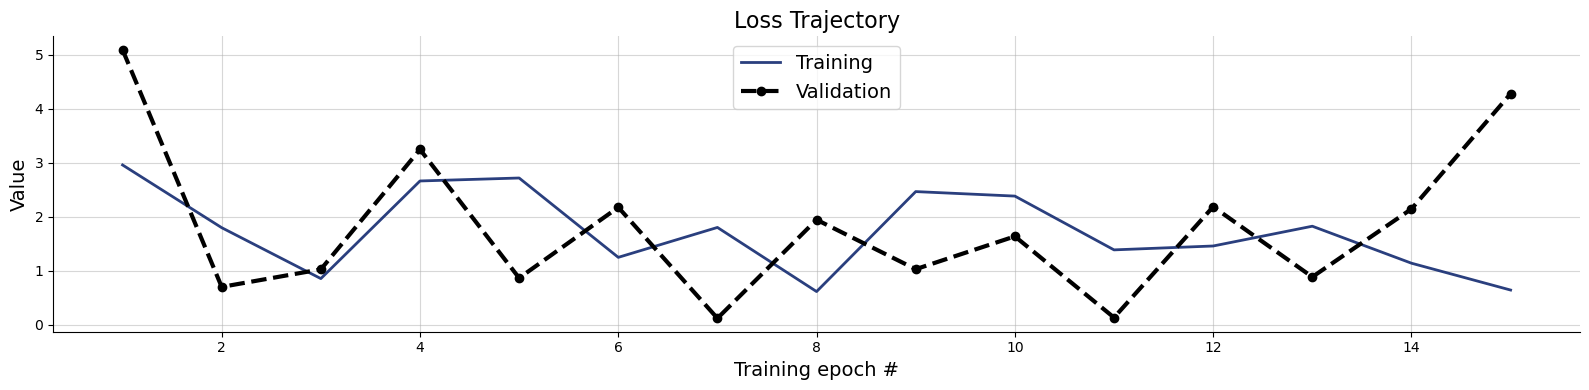

In [23]:
f = bf.diagnostics.plots.loss(history)

In [21]:
train.keys()

dict_keys(['kd', 'sim_data'])

In [22]:
# # Set the number of posterior draws you want to get
# num_samples = 1000

# # Simulate 300 scenarios and extract time series from dict
# test_sims = workflow.simulate(300)


# NEED TO USE ACTUAL TEST DATA HERE!!!!
time_series = train['sim_data']
num_samples = 1000

# Obtain 1000 samples (~20 seconds due to multi-step sampling via FlowMatching)
samples = workflow.sample(conditions={"sim_data": time_series}, num_samples=num_samples)

In [24]:
samples.keys()

dict_keys(['kd'])

In [25]:
samples['kd'].shape

(98, 1000, 1)

In [26]:
?bf.diagnostics.plots.calibration_histogram

Signature:
bf.diagnostics.plots.calibration_histogram(
    targets: dict[str, numpy.ndarray] | numpy.ndarray,
    references: dict[str, numpy.ndarray] | numpy.ndarray,
    variable_names: Sequence[str] = None,
    figsize: Sequence[float] = None,
    num_bins: int = 10,
    binomial_interval: float = 0.99,
    label_fontsize: int = 16,
    title_fontsize: int = 18,
    tick_fontsize: int = 12,
    color: str = '#132a70',
    num_col: int = None,
    num_row: int = None,
) -> matplotlib.figure.Figure
Docstring:
Creates and plots publication-ready histograms of rank statistics for simulation-based calibration
(SBC) checks according to [1].

Any deviation from uniformity indicates miscalibration and thus poor convergence
of the networks or poor combination between generative model / networks.

[1] Talts, S., Betancourt, M., Simpson, D., Vehtari, A., & Gelman, A. (2018).
Validating Bayesian inference algorithms with simulation-based calibration.
arXiv preprint arXiv:1804.06788.

Parameters

In [118]:
train['kd'].shape

(98, 1)

In [78]:
dict(prior_draws=train['prior_draws'])['prior_draws'].shape

(98, 1)

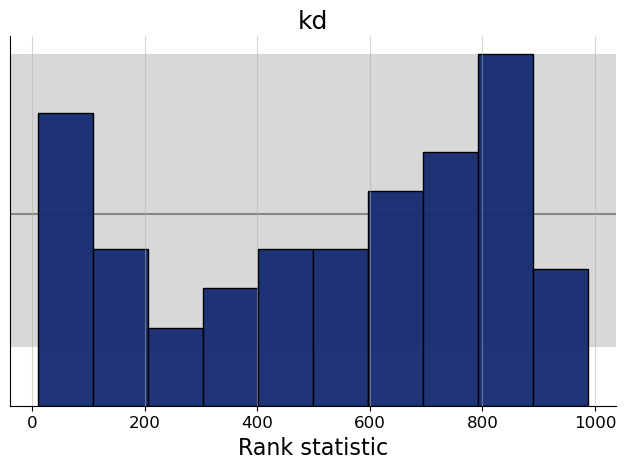

In [27]:
f = bf.diagnostics.plots.calibration_histogram(samples,train)

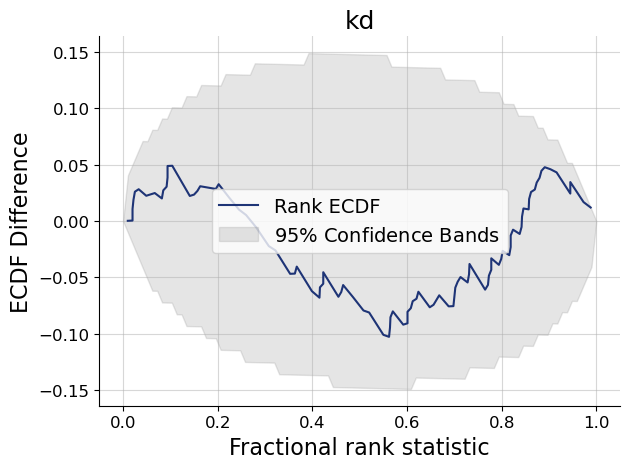

In [28]:
f = bf.diagnostics.plots.calibration_ecdf(samples, train, difference=True)

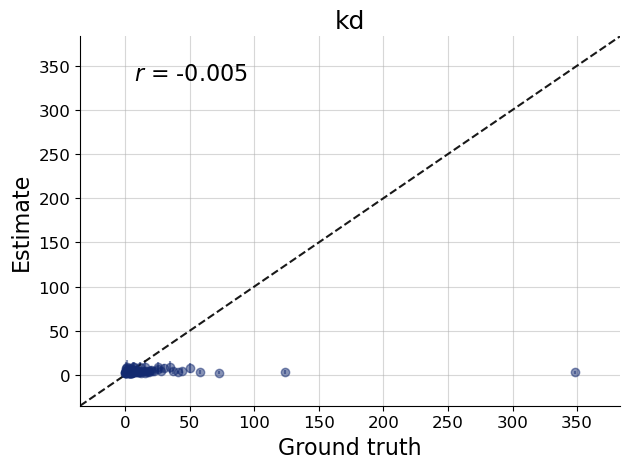

In [29]:
f = bf.diagnostics.plots.recovery(samples, train)

In [30]:
metrics = workflow.compute_diagnostics(test_data=train, num_samples=1000)


In [31]:
metrics

,kd
NRMSE,0.223217
Posterior Contraction,-13.554200
Calibration Error,0.019001


In [ ]:
# sim_mean = np.mean(observables,axis=0)
# sim_std = np.std(observables,axis=0)
# prior_mu = np.log2(5)
# prior_sigma = 2
# prior_mean = np.exp(prior_mu + 0.5 * prior_sigma**2)
# prior_std = np.sqrt((np.exp(prior_sigma**2) - 1) * np.exp(2 * prior_mu + prior_sigma**2))


# def configure_input(forward_dict):
#     """Configures dictionary of prior draws and simulated data into BayesFlow format."""

#     out_dict = {}

#     # standardization sim_data
#     sim_data = forward_dict["sim_data"].astype(np.float32)
#     norm_data = (sim_data - sim_mean) / sim_std

#     # standardization priors
#     params = forward_dict["prior_draws"].astype(np.float32)
#     norm_params = (params - prior_mean) / prior_std

#     # remove nan, inf and -inf
#     keep_idx = np.all(np.isfinite(norm_data), axis=(1, 2))
#     if not np.all(keep_idx):
#         print("Invalid value encountered...removing from batch")

#     # add to dict
#     out_dict["summary_conditions"] = norm_data[keep_idx]
#     out_dict["parameters"] = norm_params[keep_idx]

#     return out_dict